In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
nu = 0.01 / np.pi  # Viscosity

In [12]:

# ==============================================================================
# 1. DATA GENERATION FUNCTION
# ==============================================================================

def create_training_data(N_f=10000, N_ic=100, N_bc=100):
    """
    Generates training collocation points for the PDE, Initial Condition (IC), 
    and Boundary Conditions (BC).
    
    Returns: X_f, X_ic, u_ic, X_lb, X_rb, u_bc (All as PyTorch Tensors on device)
    """
    
    # --- Collocation Points (PDE Residual) ---
    # Domain: x in [-1, 1], t in [0, 1]
    x_f = np.random.uniform(-1, 1, (N_f, 1))
    t_f = np.random.uniform(0, 1, (N_f, 1))
    X_f = torch.tensor(np.hstack((x_f, t_f)), dtype=torch.float32).to(device) # Input (x, t)

    
    # --- Initial Condition Points (IC) ---
    # Time fixed at t=0
    x_ic = np.linspace(-1, 1, N_ic).reshape(-1, 1)
    t_ic = np.zeros_like(x_ic)
    u_ic_np = -np.sin(np.pi * x_ic) # Exact IC value: u(x, 0) = -sin(pi*x)
    
    X_ic = torch.tensor(np.hstack((x_ic, t_ic)), dtype=torch.float32).to(device) # Input (x, t=0)
    u_ic = torch.tensor(u_ic_np, dtype=torch.float32).to(device)                 # Output (u_exact)

    
    # --- Boundary Condition Points (BC) ---
    # Boundary: x=-1 and x=1
    t_bc = np.linspace(0, 1, N_bc).reshape(-1, 1)
    x_lb = -np.ones_like(t_bc) # Left boundary x = -1
    x_rb = np.ones_like(t_bc)  # Right boundary x = 1

    # Stack X and time domain at boundary and Transform it to tensor 
    X_lb = torch.tensor(np.hstack((x_lb, t_bc)), dtype=torch.float32).to(device) # Input (-1, t)
    X_rb = torch.tensor(np.hstack((x_rb, t_bc)), dtype=torch.float32).to(device) # Input (1, t)
    
    u_bc = torch.zeros((N_bc, 1), dtype=torch.float32).to(device) # Exact BC value: u(-1, t)=0, u(1, t)=0

    return X_f, X_ic, u_ic, X_lb, X_rb, u_bc

# ==============================================================================
# 2. MODEL DEFINITION (Dropout PINN)
# ==============================================================================

class DropoutPINN(nn.Module):
    """
    Multi-Layer Perceptron (MLP) with Tanh activation and Dropout regularization.
    """
    def __init__(self, layers, dropout_p=0.1):
        super().__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.activation = nn.Tanh()

        # Build hidden layers
        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            # Add Dropout layer after activation to prevent co-adaptation
            self.dropouts.append(nn.Dropout(dropout_p))

        # Output layer
        self.output_layer = nn.Linear(layers[-2], layers[-1])

    def forward(self, x):
        # Apply Tanh and Dropout sequentially for all hidden layers
        for i in range(len(self.layers)):
            x = self.activation(self.layers[i](x))
            x = self.dropouts[i](x)
            
        # Final linear transformation to the output (u)
        return self.output_layer(x)

# ==============================================================================
# 3. LOSS FUNCTION DEFINITION (Separated Components)
# ==============================================================================

def loss_pde(model, X_f):
    """Calculates the PDE Residual Loss (L_f) for Burgers' Equation."""
    
    X_f.requires_grad_(True) # Enable gradient tracking for differentiation
    u = model(X_f)
    
    # First derivatives (u_t, u_x)
    grads = torch.autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1] # du/dx (1st input dimension)
    u_t = grads[:, 1:2] # du/dt (2nd input dimension)
    
    # Second derivative (u_xx)
    # The gradient of u_x (du/dx) with respect to x (X_f[:, 0:1])
    u_xx = torch.autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    
    # Burgers' Equation Residual: f = u_t + u*u_x - nu*u_xx
    f = u_t + u * u_x - nu * u_xx
    
    # L_f = Mean Squared Error of the residual
    return torch.mean(f**2)

def loss_ic(model, X_ic, u_ic):
    """Calculates the Initial Condition Loss (L_ic)."""
    # L_ic = MSE of (Predicted IC - Exact IC)
    return torch.mean((model(X_ic) - u_ic)**2)

def loss_bc(model, X_lb, X_rb, u_bc):
    """Calculates the Boundary Condition Loss (L_bc)."""
    # L_bc = MSE of (Predicted BC at x=-1 - Exact BC) + MSE of (Predicted BC at x=1 - Exact BC)
    loss_lb = torch.mean((model(X_lb) - u_bc)**2)
    loss_rb = torch.mean((model(X_rb) - u_bc)**2)
    return loss_lb + loss_rb

def pinn_loss(model, X_f, X_ic, u_ic, X_lb, X_rb, u_bc):
    """Aggregates all individual loss components."""
    loss_f = loss_pde(model, X_f)
    loss_init = loss_ic(model, X_ic, u_ic)
    loss_boundary = loss_bc(model, X_lb, X_rb, u_bc)
    
    # For Burgers' Equation, weights are often set to 1.0 initially
    return loss_f + loss_init + loss_boundary

# ==============================================================================
# 4. TRAINING LOOP
# ==============================================================================

# Model Initialization
model = DropoutPINN([2, 64, 64, 64, 1], dropout_p=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
X_f, X_ic, u_ic, X_lb, X_rb, u_bc = create_training_data()

# Training loop execution
for epoch in range(10000):
    # Calculate the total loss
    loss = pinn_loss(model, X_f, X_ic, u_ic, X_lb, X_rb, u_bc)
    
    # Standard PyTorch Optimization Steps
    optimizer.zero_grad() # Reset gradients
    loss.backward()       # Backpropagation
    optimizer.step()      # Update weights

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

# ==============================================================================
# 5. MONTE CARLO DROPOUT (Uncertainty Estimation)
# ==============================================================================

# Prepare grid for inference (x in [-1, 1], t in [0, 1])
x_np = np.linspace(-1, 1, 256)
t_np = np.linspace(0, 1, 100)
X_mesh, T_mesh = np.meshgrid(x_np, t_np)
XT_input_np = np.hstack((X_mesh.flatten()[:, None], T_mesh.flatten()[:, None]))
XT_tensor = torch.tensor(XT_input_np, dtype=torch.float32).to(device)

N_samples = 100 # Number of Monte Carlo samples
predictions = []

# Activate training mode to keep Dropout layers ON during inference
model.train() 

# Collect N_samples predictions
with torch.no_grad(): # Disable gradient calculation for efficiency
    for _ in range(N_samples):
        # Forward pass: get a different prediction due to random dropout
        u_sample = model(XT_tensor).cpu().numpy().reshape(T_mesh.shape)
        predictions.append(u_sample)



# Stack all samples into an array of shape (N_samples, Nt, Nx)
predictions_stacked = np.stack(predictions, axis=0)

# Calculate Predictive Mean (Expected Value)
u_mean = np.mean(predictions_stacked, axis=0)

# Calculate Predictive Standard Deviation (Uncertainty)
u_std = np.std(predictions_stacked, axis=0)

Epoch 0, Loss = 0.468604
Epoch 1000, Loss = 0.121580
Epoch 2000, Loss = 0.093824
Epoch 3000, Loss = 0.084746
Epoch 4000, Loss = 0.069673
Epoch 5000, Loss = 0.069613
Epoch 6000, Loss = 0.054409
Epoch 7000, Loss = 0.055321
Epoch 8000, Loss = 0.044963
Epoch 9000, Loss = 0.049303


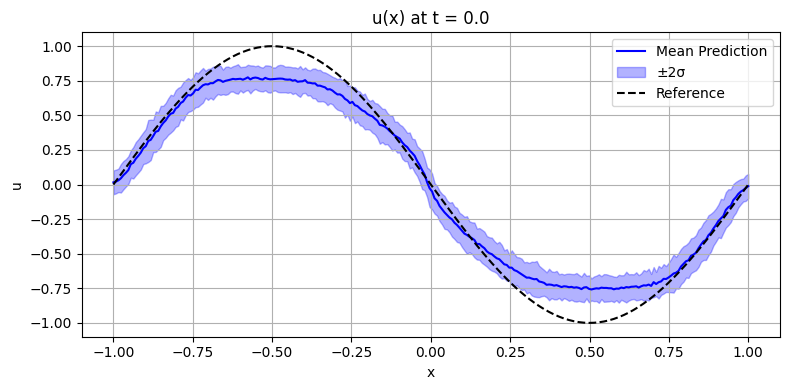

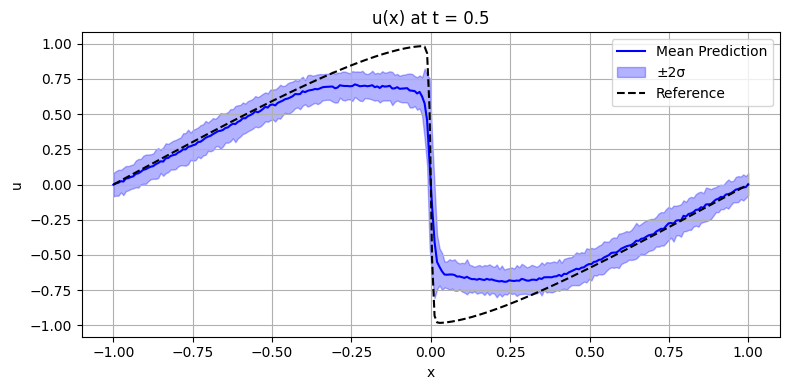

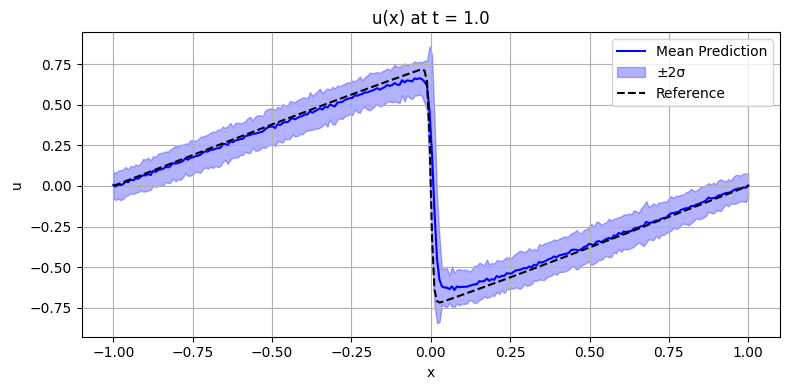

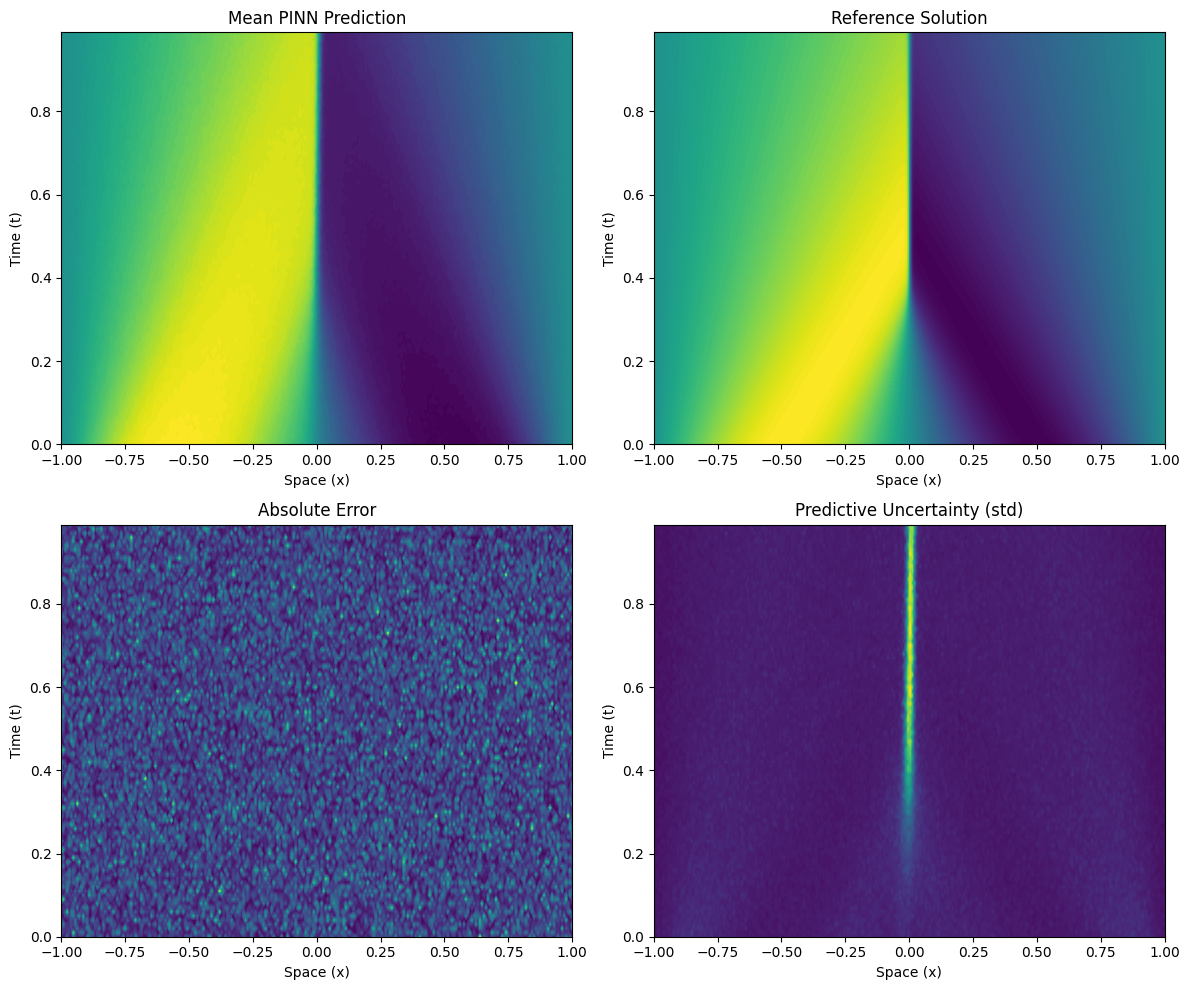

In [13]:
# --- Line Plots with ±2σ bands ---
def plot_with_uncertainty(x, mean, std, reference, t_val):
    """
    Plots the mean prediction along with the uncertainty band (±2 standard deviations) 
    against the reference solution at a specific time t.
    """
    plt.figure(figsize=(8, 4))
    
    # Plot the predicted mean solution
    plt.plot(x, mean, label="Mean Prediction", color="blue")
    
    # Fill the region representing the epistemic uncertainty band (Mean ± 2*Std Dev)
    plt.fill_between(x, mean - 2*std, mean + 2*std, alpha=0.3, label="±2σ", color="blue")
    
    # Plot the true/reference solution for validation
    plt.plot(x, reference, '--', label="Reference", color="black")
    
    # Set plot metadata
    plt.title(f"u(x) at t = {t_val}")
    plt.xlabel("x"); plt.ylabel("u")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# Prepare 1D spatial coordinate for line plots
x_ref_1d = x_ref.flatten()

# Plot solution at selected time slices
for t_val in [0.0, 0.5, 1.0]:
    # Find the index in the time array (t_ref) closest to the target time (t_val)
    idx = np.argmin(np.abs(t_ref - t_val))
    
    # Call the plotting function using the slice corresponding to the found index
    plot_with_uncertainty(
        x_ref_1d, 
        u_mean[idx],   # Slice the mean prediction at time index idx
        u_std[idx],    # Slice the standard deviation at time index idx
        U_exact[idx],  # Slice the reference solution at time index idx
        t_val
    )

# ==============================================================================
# --- Contour Plots (2D Visualization) ---
# ==============================================================================

# Load reference data (kept for context, assuming this was executed previously)
# data = np.load("/kaggle/input/pinn-dataset/Burgers.npz")
# x_ref = data['x']
# t_ref = data['t']
# U_exact_ref = data['usol']
# U_exact = U_exact_ref.T # Transposed to (Time, Space)

# Create 2D meshgrid for plotting (T_ref is used for the vertical axis index in the original code, X_ref for the horizontal)
X_ref, T_ref = np.meshgrid(x_ref, t_ref) 
# Note: T_ref is the array of time coordinates, X_ref is the array of space coordinates.

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top-Left: Mean PINN Prediction
axs[0, 0].contourf(X_ref, T_ref, u_mean, 100) # u_mean must be (Time, Space) or (T_ref.shape)
axs[0, 0].set_title("Mean PINN Prediction")

# Top-Right: Reference Solution
axs[0, 1].contourf(X_ref, T_ref, U_exact, 100)
axs[0, 1].set_title("Reference Solution")

# Bottom-Left: Absolute Error
# abs_error must be calculated as np.abs(u_mean - U_exact)
axs[1, 0].contourf(X_ref, T_ref, abs_error, 100)
axs[1, 0].set_title("Absolute Error")

# Bottom-Right: Predictive Uncertainty (Standard Deviation)
axs[1, 1].contourf(X_ref, T_ref, u_std, 100)
axs[1, 1].set_title("Predictive Uncertainty (std)")


# Set common labels for all subplots
for ax in axs.flat:
    ax.set_xlabel("Space (x)")
    ax.set_ylabel("Time (t)")
    
plt.tight_layout()
plt.show()